In [1]:
# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn import linear_model, metrics
import pickle

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

#date and time
import datetime as dt
current_date = dt.datetime.now()

# Data Manipulation
import numpy as np
import pandas as pd

In [2]:
ticker = 'AAPL'
exchange = ''

with open(f'''C:/Users/Anton/Desktop/Backtesting/BANKA/data_json_{ticker.replace(exchange, '')}.pickle''',  # УКАЗАТЬ СВОЙ ПУТЬ !!!!
          'rb') as f:
    data_json = pickle.load(f)

with open(
        f'''C:/Users/Anton/Desktop/Backtesting/BANKA/data_json_keyratios_{ticker.replace(exchange, '')}.pickle''',  # УКАЗАТЬ СВОЙ ПУТЬ !!!!
        'rb') as f:
    data_json_keyratios = pickle.load(f)

#     print(data_json)
try:
    date_list = pd.Series(data_json['financials']['annuals']['Fiscal Year'])
    keyratios = pd.DataFrame(data_json_keyratios['Fundamental'], index=[0])
    income_df = pd.DataFrame(data_json['financials']['annuals']['income_statement']).set_index(
        date_list).replace('No Debt', 0).replace('At Loss', 0).replace('-', 0).replace('', 0).replace('N/A',
                                                                                                      0).astype(
        float)
    balance_df = pd.DataFrame(data_json['financials']['annuals']['balance_sheet']).set_index(date_list).replace(
        'No Debt', 0).replace('At Loss', 0).replace('', 0).replace('-', 0).replace('N/A', 0).astype(float)
    cashflow_df = pd.DataFrame(data_json['financials']['annuals']['cashflow_statement']).set_index(
        date_list).replace('No Debt', 0).replace('At Loss', 0).replace('', 0).replace('-', 0).replace('N/A',
                                                                                                      0).astype(
        float)
    valuation_ratios_df = pd.DataFrame(data_json['financials']['annuals']['valuation_ratios']).set_index(
        date_list).replace('No Debt', 0).replace('At Loss', 0).replace('', 0).replace('-', 0).replace('N/A',
                                                                                                      0).astype(
        float)
    valuation_and_quality_df = pd.DataFrame(
        data_json['financials']['annuals']['valuation_and_quality']).set_index(date_list).drop(
        ['Restated Filing Date', 'Filing Date', 'Earnings Release Date'], axis=1).replace('', 0).replace(
        'No Debt', 0).replace('At Loss', 0).replace('-', 0).replace('N/A', 0).astype(float)
    common_size_ratios_df = pd.DataFrame(data_json['financials']['annuals']['common_size_ratios']).set_index(
        date_list).replace('No Debt', 0).replace('At Loss', 0).replace('', 0).replace('-', 0).replace('N/A',
                                                                                                      0).replace(
        'Negative Tangible Equity', 0).astype(float)
    # per_share_data_array_df = pd.DataFrame(data_json['financials']['annuals']['per_share_data_array']).set_index(date_list).replace('-', 0).replace('N/A', 0).astype(float)
    per_share_data_df = pd.DataFrame(data_json['financials']['annuals']['per_share_data_array']).set_index(
        date_list).replace('', 0).replace('No Debt', 0).replace('-', 0).replace('N/A', 0).astype(float)

    check = 1
except:
    check = 0
    # print('Data error')
    pass

In [3]:

per_share_data_df.index.tolist()


with open(f'C:/Users/Anton/Desktop/CODE_SMILE/BACKTESTING/YAHOOOOOO.pickle', 'rb') as f:  # УКАЗАТЬ СВОЙ ПУТЬ !!!!
    price_yahoo_main = pickle.load(f)
price_yahoo_main = price_yahoo_main['Adj Close'].fillna(method='backfill')

In [4]:
period = per_share_data_df.index.tolist()

index = 'SPY'

return_per_year_list = []
index_return_per_year_list = []

price_yahoo_dl = yf.download(index)['Adj Close'].fillna(method='backfill')

for i in range(len(income_df)):
    try:
        year_return = price_yahoo_main[ticker][period[i].split('-')[0]].fillna(method='backfill').dropna()
        index_year_return = price_yahoo_dl[period[i].split('-')[0]].fillna(method='backfill').dropna()
        profit = (year_return.iloc[-1] - year_return.iloc[0]) / year_return.iloc[0]
        index_profit = (index_year_return.iloc[-1] - index_year_return.iloc[0]) / index_year_return.iloc[0]
#         print(profit)
#         profit = profit.replace([np.inf, -np.inf], np.nan).dropna()
        return_per_year_list.append(profit)
        index_return_per_year_list.append(index_profit)
        
    except:
        year_return = price_yahoo_main[ticker][str(int(period[-2].split('-')[0])+1)].fillna(method='backfill').dropna()
        index_year_return = price_yahoo_dl[str(int(period[-2].split('-')[0])+1)].fillna(method='backfill').dropna()
        profit = (year_return.iloc[-1] - year_return.iloc[0]) / year_return.iloc[0]
        index_profit = (index_year_return.iloc[-1] - index_year_return.iloc[0]) / index_year_return.iloc[0]
        
#         print(price_yahoo_main[ticker][str(int(period[-2].split('-')[0])+1)])
#         print(profit)
#         profit = profit.replace([np.inf, -np.inf], np.nan).dropna()
        return_per_year_list.append(profit)
        index_return_per_year_list.append(index_profit)
        
    

    
DF_corr = pd.concat([per_share_data_df, common_size_ratios_df, valuation_and_quality_df, valuation_ratios_df, cashflow_df, balance_df, \
           income_df],axis=1, ignore_index=False)

[*********************100%***********************]  1 of 1 completed


In [5]:
# удаляем дубли
DF_corr = DF_corr.T.groupby(level=0).first().T

In [6]:
KNN_DF = income_df
KNN_DF['Returns'] = return_per_year_list
KNN_DF['INDEX Returns'] = index_return_per_year_list

In [7]:
Y= np.where(KNN_DF['Returns']>KNN_DF['INDEX Returns'],1,0)
X = DF_corr[['ROCE %','EV-to-EBITDA', 'YoY Rev. per Sh. Growth', 'Beneish M-Score', 'Interest Coverage', \
  'Change In Other Working Capital','Other Income (Expense)', 'PE Ratio without NRI', 'Asset Turnover', 'EV-to-Revenue',\
 'Shares Buyback Ratio %', 'Scaled Net Operating Assets', 'Equity-to-Asset']]


# Оценка критериев отбора признаков

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature extraction

test = SelectKBest(score_func=f_classif, k=4)

fit = test.fit(X, Y)

np.set_printoptions(precision=3)

features = fit.transform(X)

feat = dict(zip(X.columns.tolist(), fit.scores_))
feach_f_score = pd.DataFrame(feat, index=[0])
# feach_f_score.T.sort_values(feach_f_score.T[]) 
# feach_f_score.T[0].dropna().sort_values(ascending=False).head(30)

TOP_feach = feach_f_score.T[0].dropna().sort_values(ascending=False)[:60].index.tolist()
# feach_f_score

In [9]:
X = DF_corr[TOP_feach]

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    random_state=17) # random_state - для воспроизводимости

# Выбираем лучшее количество кластеров

In [12]:
# accuracy_1 = accuracy_score(y_test, knn_prediction)
# accuracy_1


accuracy_1_max = 0
accuracy_2_max = 0
num1 = 0
num2 = 0

for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn_model_1 = knn.fit(x_train, y_train)
    knn_predictions_1 = knn.predict(x_test)
    accuracy_1 = accuracy_score(y_test, knn_predictions_1)
    print(f'Accuracy_1: {accuracy_1}', 'n_neighbors:', i)
    
    if accuracy_1 > accuracy_1_max:
        accuracy_1_max = accuracy_1
        num1 = i

print(f'MAX Accuracy_1: {accuracy_1_max}')    
print(f'n_neighbors Accuracy_1: {num1}') 

Accuracy_1: 0.5 n_neighbors: 1
Accuracy_1: 0.25 n_neighbors: 2
Accuracy_1: 0.25 n_neighbors: 3
Accuracy_1: 0.375 n_neighbors: 4
Accuracy_1: 0.375 n_neighbors: 5
Accuracy_1: 0.375 n_neighbors: 6
Accuracy_1: 0.5 n_neighbors: 7
Accuracy_1: 0.375 n_neighbors: 8
Accuracy_1: 0.5 n_neighbors: 9
Accuracy_1: 0.375 n_neighbors: 10
Accuracy_1: 0.5 n_neighbors: 11
Accuracy_1: 0.5 n_neighbors: 12
Accuracy_1: 0.5 n_neighbors: 13
Accuracy_1: 0.5 n_neighbors: 14
Accuracy_1: 0.5 n_neighbors: 15
Accuracy_1: 0.75 n_neighbors: 16
Accuracy_1: 0.625 n_neighbors: 17
Accuracy_1: 0.625 n_neighbors: 18
Accuracy_1: 0.625 n_neighbors: 19
MAX Accuracy_1: 0.75
n_neighbors Accuracy_1: 16


In [22]:
knn = KNeighborsClassifier(n_neighbors=16)

knn_model = knn.fit(x_train, y_train)

knn_prediction = knn.predict(x_test)
accuracy_1 = accuracy_score(y_test, knn_prediction)
accuracy_1


# scat_mtrx = pd.plotting.scatter_matrix(X, c=Y, figsize=(25, 25), marker='o',
#                                        hist_kwds={'bins': 20}, s=40, alpha=.8)

0.75

In [29]:
knn_pred = knn.predict(X)
knn_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0])

In [24]:
Y

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0])

<AxesSubplot:>

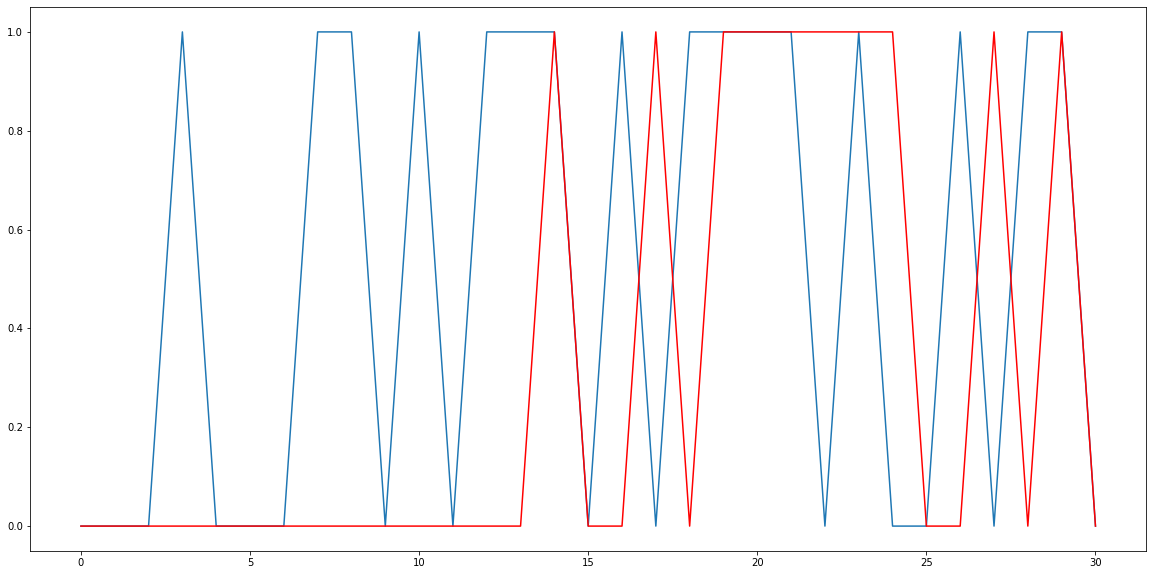

In [32]:
plot_df = pd.DataFrame()
plot_df['Real'] = Y
plot_df['Pred'] = knn_pred


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plot_df['Real'].plot( ax=ax)
plot_df['Pred'].plot( ax=ax, color='red')


In [53]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'objective': 'binary:logistic',
          'max_depth': 6,
          'eta': 0.1}

num_rounds = 30

X_xgb = xgb.DMatrix(X, Y)

xgb_model = xgb.train(params, dtrain, num_boost_round=num_rounds)


xgb_pred = xgb_model.predict(X_xgb)
xgb_pred

[17:28:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.34 , 0.135, 0.162, 0.771, 0.138, 0.596, 0.385, 0.774, 0.854,
       0.157, 0.862, 0.676, 0.822, 0.796, 0.871, 0.204, 0.789, 0.165,
       0.468, 0.468, 0.654, 0.402, 0.11 , 0.3  , 0.11 , 0.113, 0.743,
       0.331, 0.589, 0.738, 0.374], dtype=float32)

[17:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	test-logloss:0.68624	train-logloss:0.65508
[1]	test-logloss:0.67979	train-logloss:0.62162
[2]	test-logloss:0.67376	train-logloss:0.59206
[3]	test-logloss:0.66812	train-logloss:0.56581
[4]	test-logloss:0.66284	train-logloss:0.54241
[5]	test-logloss:0.67184	train-logloss:0.51667
[6]	test-logloss:0.66235	train-logloss:0.49410
[7]	test-logloss:0.69620	train-logloss:0.46855
[8]	test-logloss:0.73016	train-logloss:0.44590
[9]	test-logloss:0.72454	train-logloss:0.42613
[10]	test-logloss:0.73999	train-logloss:0.41033
[11]	test-logloss:0.77297	train-logloss:0.39248
[12]	test-logloss:0.80311	train-logloss:0.37934
[13]	test-logloss:0.79210	train-logloss:0.36836
[14]	test-logloss:0.82379	tr

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

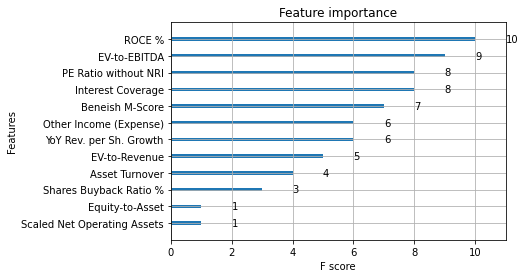

In [41]:
evals = [(dtest, 'test'), (dtrain, 'train')]
xgb_model = xgb.train(params, dtrain, num_boost_round=num_rounds, evals=evals)
xgb.plot_importance(xgb_model)

<AxesSubplot:>

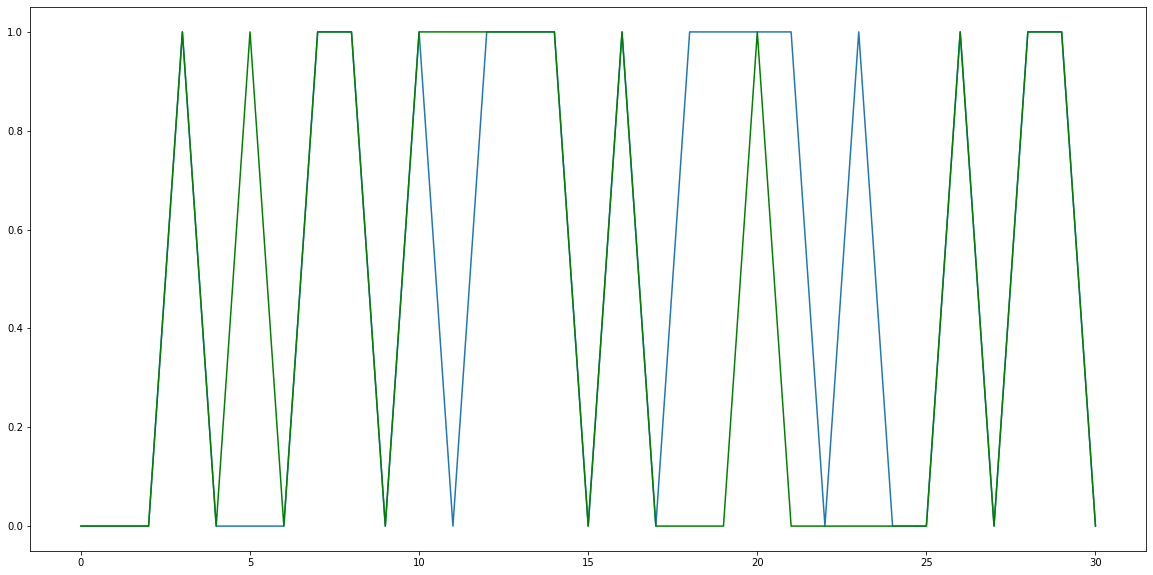

In [52]:
plot_df = pd.DataFrame()
plot_df['Real'] = Y
plot_df['Pred'] = knn_pred
plot_df['xgb_pred']  = xgb_pred


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plot_df['Real'].plot( ax=ax)
# plot_df['Pred'].plot( ax=ax, color='red')
plot_df['xgb_pred'].round().plot( ax=ax, color='green')

# K-means

In [39]:
import numpy as np
from sklearn.cluster import KMeans


kmeans_model = KMeans(n_clusters=4, random_state=17)
kmeans_model = kmeans_model.fit(x_train, y_train)
kmeans_prediction = kmeans_model.predict(x_test)
accuracy_1 = accuracy_score(y_test, kmeans_prediction)
accuracy_1

0.375

# DBSCAN

In [31]:
import pickle
import numpy as np
from sklearn.cluster import DBSCAN


db = DBSCAN(eps=0.6, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# labels = db.labels_

# plt.scatter(X.iloc[:,:1], Y, s=40, c=kmeans_model.labels_, marker='o', alpha=0.8, label='data')
# plt.show()

In [2]:
# Read the data
Df = yf.download('^NSEI', '2012-12-31', current_date, auto_adjust=True)
Df2 = yf.download('SPY', '2012-12-31', current_date, auto_adjust=True)
Df3 = yf.download('^IRX', '2012-12-31', current_date, auto_adjust=True)

Df.info()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2091 entries, 2012-12-31 to 2021-07-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2091 non-null   float64
 1   High    2091 non-null   float64
 2   Low     2091 non-null   float64
 3   Close   2091 non-null   float64
 4   Volume  2091 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 98.0 KB


# фичи

In [3]:
# Calculate 3-day moving average of close prices
Df['S_3'] = Df['Close'].shift(1).rolling(window=3).mean()

# Calculate 15-day moving average of close prices
Df['S_15'] = Df['Close'].shift(1).rolling(window=15).mean()

# Calculate 60-day moving average of close prices
Df['S_60'] = Df['Close'].shift(1).rolling(window=60).mean()

# Calculate the correlation between close price and 3 day moving average
Df['Corr'] = Df['Close'].shift(1).rolling(window=10).corr(Df['S_3'].shift(1))

Df['Close_Y'] = Df['Close']
# Df['Std_D'] = Df['Open']-Df['Low']

Df['OD'] = Df['Open']-Df['Open'].shift(1)
Df['OL'] = Df['Open']-Df['Close'].shift(1)
# 
Df['SPY'] = Df2['Close'] 

Df['Treasury'] = Df3['Close'] 



In [4]:
X = Df[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr', 'SPY', 'Treasury']]
# X = Df[['SPY']]


In [5]:
yU = Df['Close_Y']

In [6]:
imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('linear',LinearRegression())]     
pipeline = Pipeline(steps)

In [7]:
parameters = {'linear__fit_intercept':[0,1]}

In [8]:
reg = GridSearchCV(pipeline, parameters, cv=5)

In [9]:
t = .7
split = int(t*len(Df))
reg.fit(X[:split],yU[:split])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputation',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

In [10]:
best_fit = reg.best_params_['linear__fit_intercept']
best_fit

1

In [11]:
reg = LinearRegression(fit_intercept=best_fit)

In [12]:
X = imp.fit_transform(X,yU)

In [13]:
reg.fit(X[:split], yU[:split])
y_predict = reg.predict(X)

# Assign the predicted values to a new column in the dataframe
Df.reset_index(inplace=True)

Df['Predict close'] = y_predict
# Df.loc[Df['Predict close'] < 0, 'Predict close'] = 0

In [14]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2091 non-null   datetime64[ns]
 1   Open           2091 non-null   float64       
 2   High           2091 non-null   float64       
 3   Low            2091 non-null   float64       
 4   Close          2091 non-null   float64       
 5   Volume         2091 non-null   int64         
 6   S_3            2088 non-null   float64       
 7   S_15           2076 non-null   float64       
 8   S_60           2031 non-null   float64       
 9   Corr           2078 non-null   float64       
 10  Close_Y        2091 non-null   float64       
 11  OD             2090 non-null   float64       
 12  OL             2090 non-null   float64       
 13  SPY            2038 non-null   float64       
 14  Treasury       1628 non-null   float64       
 15  Predict close  2091 n

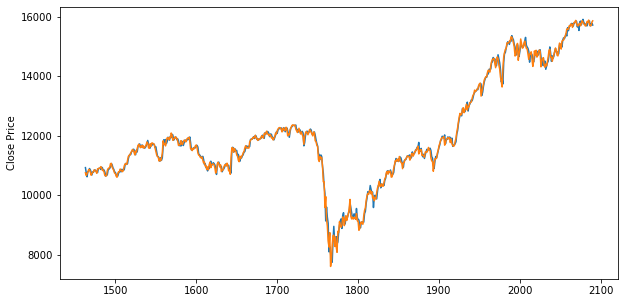

In [15]:


Df['Predict close'][split:].plot(figsize=(10, 5))
Df['Close'][split:].plot(figsize=(10, 5))
plt.ylabel("Close Price")
plt.show()

# Логистическая регрессия


In [16]:
df = pdr.get_data_yahoo('^NSEI', '2012-12-31', current_date)
df = df.fillna(method='backfill')
df = df.iloc[:,:4]
df.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2091 entries, 2012-12-31 to 2021-07-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2091 non-null   float64
 1   High    2091 non-null   float64
 2   Low     2091 non-null   float64
 3   Close   2091 non-null   float64
dtypes: float64(4)
memory usage: 81.7 KB


In [17]:
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_10'] = df['Close'].rolling(window=10).mean()

df['Corr'] = df['Close'].rolling(window=10).corr(df['S_3'])

df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.fillna(method='backfill')
X = df.iloc[:,:9]
X



# X = Df[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr', 'SPY', 'Treasury']]


,Open,High,Low,Close,S_3,S_10,Corr,RSI,Open-Close
Date,,,,,,,,,
2012-12-31,5901.200195,5919.000000,5897.149902,5905.100098,5969.283366,5982.959961,0.475179,74.610074,77.500000
2013-01-02,5982.600098,6006.049805,5982.000000,5993.250000,5969.283366,5982.959961,0.475179,74.610074,77.500000
2013-01-03,6015.799805,6017.000000,5986.549805,6009.500000,5969.283366,5982.959961,0.475179,74.610074,22.549805
2013-01-04,6011.950195,6020.750000,5981.549805,6016.149902,6006.299967,5982.959961,0.475179,74.610074,2.450195
2013-01-07,6042.149902,6042.149902,5977.149902,5988.399902,6004.683268,5982.959961,0.475179,74.610074,26.000000
...,...,...,...,...,...,...,...,...,...
2021-07-08,15855.400391,15885.750000,15682.900391,15727.900391,15808.600260,15780.735059,0.558481,49.651225,-24.250000
2021-07-09,15688.250000,15730.849609,15632.750000,15689.799805,15765.783529,15763.680078,0.594061,46.781734,-39.650391
2021-07-12,15766.799805,15789.200195,15644.750000,15692.599609,15703.433268,15751.470020,0.608713,47.031680,77.000000


<AxesSubplot:>

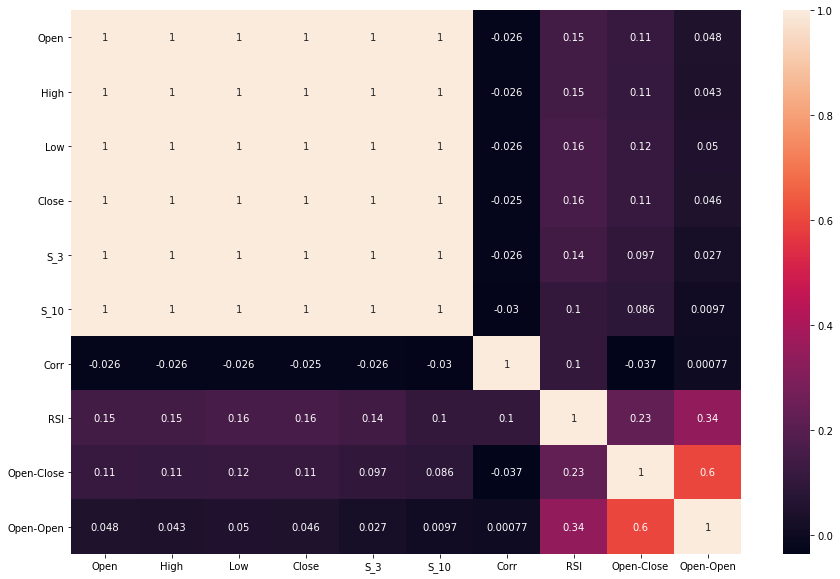

In [18]:
cov_matrix = df.cov()
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)

In [19]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

In [20]:
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
X_train.fillna(method='backfill')

,Open,High,Low,Close,S_3,S_10,Corr,RSI,Open-Close
Date,,,,,,,,,
2012-12-31,5901.200195,5919.000000,5897.149902,5905.100098,5969.283366,5982.959961,0.475179,74.610074,77.500000
2013-01-02,5982.600098,6006.049805,5982.000000,5993.250000,5969.283366,5982.959961,0.475179,74.610074,77.500000
2013-01-03,6015.799805,6017.000000,5986.549805,6009.500000,5969.283366,5982.959961,0.475179,74.610074,22.549805
2013-01-04,6011.950195,6020.750000,5981.549805,6016.149902,6006.299967,5982.959961,0.475179,74.610074,2.450195
2013-01-07,6042.149902,6042.149902,5977.149902,5988.399902,6004.683268,5982.959961,0.475179,74.610074,26.000000
...,...,...,...,...,...,...,...,...,...
2018-12-14,10784.500000,10815.750000,10752.099609,10805.450195,10778.199870,10720.320117,0.763156,57.534607,-7.049805
2018-12-17,10853.200195,10900.349609,10844.849609,10888.349609,10828.449870,10720.780078,0.746844,61.685711,47.750000
2018-12-18,10850.900391,10915.400391,10819.099609,10908.700195,10867.500000,10724.700098,0.759435,62.680759,-37.449219


In [21]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

probability = model.predict_proba(X_test)
print(probability)

[[0.60283376 0.39716624]
 [0.5328961  0.4671039 ]
 [0.33900942 0.66099058]
 ...
 [0.46138132 0.53861868]
 [0.3848641  0.6151359 ]
 [0.42813905 0.57186095]]


In [22]:
predicted = model.predict(X_test)

In [23]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.48      0.33      0.39       277
           1       0.57      0.72      0.64       351

    accuracy                           0.54       628
   macro avg       0.53      0.52      0.51       628
weighted avg       0.53      0.54      0.53       628



In [24]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)


C:\Users\Anton\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Df['Predict close']
# df['Close'] = Df['Predict close'].tolist()
# df['Close']

In [26]:
Df['Predict close'][split:]

1463    10927.801926
1464    10753.136166
1465    10619.754302
1466    10794.782635
1467    10806.320445
            ...     
2086    15851.363592
2087    15684.428896
2088    15750.035784
2089    15779.162716
2090    15712.521118
Name: Predict close, Length: 628, dtype: float64

In [54]:

# df['Close'][split:] = Df['Predict close'][split:].tolist() 

# df['Open'][-1] = Df['Predict close'].tolist()[-1] 

X2 = df[['Open', 'High', 'Low', 'Close', 'S_10', 'Corr', 'RSI', 'Open-Close', 'Open-Open']]
X2[split:]

,Open,High,Low,Close,S_10,Corr,RSI,Open-Close,Open-Open
Date,,,,,,,,,
2018-12-21,10944.250000,10963.650391,10738.650391,10927.801926,10784.225000,0.844817,48.832065,-7.450195,59.049805
2018-12-24,10780.900391,10782.299805,10649.250000,10753.136166,10801.729980,0.765621,43.557830,26.900391,-163.349609
2018-12-26,10635.450195,10747.500000,10534.549805,10619.754302,10819.799902,0.659916,48.122223,-28.049805,-145.450195
2018-12-27,10817.900391,10834.200195,10764.450195,10794.782635,10824.019922,0.665123,51.409150,88.050781,182.450195
2018-12-28,10820.950195,10893.599609,10817.150391,10806.320445,10830.854980,0.673589,56.338233,41.150391,3.049805
...,...,...,...,...,...,...,...,...,...
2021-07-08,15855.400391,15885.750000,15682.900391,15851.363592,15780.735059,0.558481,49.651225,-24.250000,35.800781
2021-07-09,15688.250000,15730.849609,15632.750000,15684.428896,15763.680078,0.594061,46.781734,-39.650391,-167.150391
2021-07-12,15766.799805,15789.200195,15644.750000,15750.035784,15751.470020,0.608713,47.031680,77.000000,78.549805


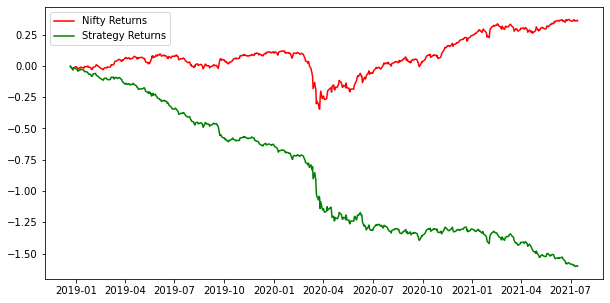

Date
2012-12-31         NaN
2013-01-02    0.014817
2013-01-03    0.002708
2013-01-04    0.001106
2013-01-07   -0.004623
                ...   
2021-07-08    0.002322
2021-07-09   -0.010587
2021-07-12    0.004174
2021-07-13    0.001848
2021-07-14   -0.004232
Name: Nifty_returns, Length: 2091, dtype: float64

In [60]:

df['Predicted_Signal'] = model.predict(X)
df['Nifty_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Nifty_returns = np.cumsum(df[split:]['Nifty_returns'])

df['Startegy_returns'] = df['Nifty_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nifty_returns, color='r',label = 'Nifty Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()
df['Predicted_Signal'][::-1].head(50)
df['Nifty_returns']

In [58]:
 df_res['Predicted_Signal'] 

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
2086   -1
2087   -1
2088   -1
2089   -1
2090   -1
Name: Predicted_Signal, Length: 2091, dtype: int32

In [59]:
df[split:]['Nifty_returns']

Date
2018-12-21   -0.002185
2018-12-24   -0.016113
2018-12-26   -0.012482
2018-12-27    0.016347
2018-12-28    0.001068
                ...   
2021-07-08    0.002322
2021-07-09   -0.010587
2021-07-12    0.004174
2021-07-13    0.001848
2021-07-14   -0.004232
Name: Nifty_returns, Length: 628, dtype: float64

In [44]:
df[split:]['Nifty_returns'].values

array([-2.18453593e-03, -1.61127288e-02, -1.24815683e-02,  1.63470479e-02,
        1.06826133e-03,  8.33441908e-03, -3.73039663e-03, -7.12177704e-03,
       -9.21452909e-03,  9.65067349e-03, -7.77506506e-04,  6.46481443e-03,
        3.62437095e-04, -2.53265704e-03, -2.70241808e-03, -2.91600191e-03,
        1.18818136e-02,  1.83571039e-03, -4.13237986e-04, -3.53654901e-03,
        6.90206866e-03, -2.00694578e-03, -8.24182620e-03,  1.66532754e-03,
       -6.26071574e-03, -1.29270263e-02,  4.29223725e-03, -5.95326169e-04,
        1.53657937e-02,  2.71496889e-03,  2.45392393e-03,  4.75493507e-03,
        9.92306738e-03, -3.82445584e-03, -9.22447181e-03, -4.62864874e-03,
       -8.12880395e-03, -1.31343882e-03, -7.73521534e-03, -5.02525019e-03,
        1.26128240e-03,  9.10911497e-03,  3.81105025e-03,  2.28819447e-03,
       -2.24629343e-03,  8.02589467e-03, -1.55629642e-03, -1.88184827e-03,
        2.65690254e-03,  1.43642309e-02,  4.83695980e-03, -3.38137934e-03,
        2.10123069e-03,  